OWL-ViT
====

**Simple Open-Vocabulary Object Detection with Vision Transformers**

 * Paper: https://arxiv.org/abs/2205.06230

![OWL-ViT training](../assets/owlvit_training.jpg)



OWL-ViT is an open-vocabulary object detector that performs detection in a **class-agnostic** manner. 
 * Given an input image, it first identifies regions that may contain objects without assuming any predefined categories.
 * Then, using a list of free-text queries, the model scores each region based on how likely it is to match each query.


**Instalation**

```bash
pip install torch torchvision
pip install -q git+https://github.com/huggingface/transformers.git
pip install matplotlib
pip install supervision
```

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv

import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = OwlViTProcessor.from_pretrained(
    "google/owlvit-base-patch32"
)
model = OwlViTForObjectDetection.from_pretrained(
    "google/owlvit-base-patch32"
)

model.eval().to(device);

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "../samples/plants.jpg"
text_queries = ["a plant", "a flower", "a tree", "a vase"]
image = Image.open(image_path).convert("RGB")
w, h = image.size
image = image.resize((w // 4, h // 4))

# Process image and text inputs
inputs = processor(
    text=[text_queries], images=image,
    return_tensors="pt"
).to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")


input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [3]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [4]:
# rescale boxes to image size
target_sizes = torch.tensor([(image.height, image.width)])

# Convert bboxes to xyxy format
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes,
    threshold=0.1, text_labels=[text_queries]
)


boxes = results[0]["boxes"]
scores = results[0]["scores"]
text_labels = results[0]["text_labels"]

for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {text_label} "
        f"with confidence {round(score.item(), 3)} "
        f"at location {box}"
    )

Detected a plant with confidence 0.107 at location [102.39, 22.71, 201.05, 270.97]
Detected a vase with confidence 0.155 at location [38.44, 157.63, 99.93, 267.99]
Detected a vase with confidence 0.172 at location [38.09, 158.26, 100.21, 267.0]
Detected a vase with confidence 0.238 at location [116.19, 127.45, 196.1, 271.34]
Detected a vase with confidence 0.178 at location [116.73, 124.51, 195.9, 270.6]


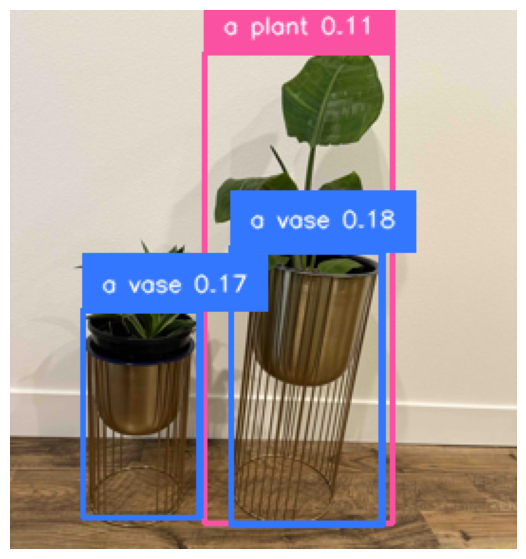

In [9]:
detections = sv.Detections(
    xyxy=boxes.cpu().numpy(),
    confidence=scores.cpu().numpy(),
    class_id=results[0]["labels"].cpu().numpy()
)

box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.4)

annotated_image = box_annotator.annotate(
    scene=np.array(image),
    detections=detections
)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=[
        f"{txt} {round(sc.item(), 2)}"
        for txt, sc in zip(text_labels, scores)
    ]
)


fig = plt.figure(figsize=(7, 7), dpi=100)
plt.imshow(annotated_image)
plt.axis("off")
plt.show()